# Optimization of a CNN to classify RGB images

The goal of this exercice is to train and optimize an artificial neural network on images from the [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) database. In that case, the images are classifiy according to 10 different classes : airplane, car, truck, bird, cat, dog, deer, horse, frog and ship. 
There is several difficulties in that case :
- several classes are quite close (sucah as car and truck) and will require a thourough training of the network to efficiently differentiate the images
- the images are RGB and of very low quality

## I - Downloading the CIFAR image database

First step - we will all the necessary libraries. 

In [ ]:
# to show images directly in the notebook
%matplotlib inline

# to display tensorboard directly in the notebook
%load_ext tensorboard

import numpy as np    # scientific computing 
import matplotlib.pyplot as plt   # plotting and visualisation

# import keras and its libraries
%tensorflow_version 2.x
from tensorflow import keras
from keras.models import Sequential # Model type to be used
from keras import regularizers
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization  # Making a model
from keras.utils import np_utils  # NumPy related tools
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import random 

Then we import the CIFAR database and display few examples. 

170500096/170498071 [==============================] - 6s 0us/step

The CIFAR database contains 50000 images for training and 10000 images for testing/validation
X_train/X_val are composed of four dimensions. For example, X_train is (50000, 32, 32, 3) and are respectively:
- the number of images in the database
- the 2D size of the images
- the number of channels (for example the images are RGB and contain 3 channels)



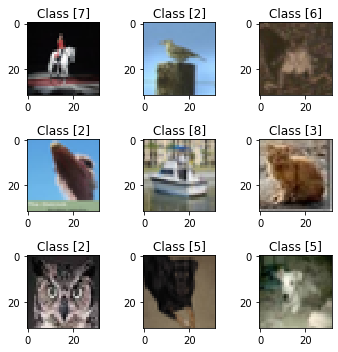

In [ ]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

print('')
print('The CIFAR database contains {} images for training and {} images for testing/validation'.format(len(X_train), len(X_val)))
print('X_train/X_val are composed of four dimensions. For example, X_train is {} and are respectively:'.format(X_train.shape))
print('- the number of images in the database')
print('- the 2D size of the images')
print('- the number of channels (for example the images are RGB and contain 3 channels)')
print('')

In [ ]:
im = X_train[0]
print('The size of the image is {} pixels'.format(im.shape))
print('The minimum pixel value is {} and the maxium  {}'.format(np.min(im), np.max(im)))

The size of the image is (32, 32, 3) pixels
The minimum pixel value is 0 and the maxium  255


## II - Formatting the data

As already discussed for the MNIST, we need to normalize the images before working with them. In the case of the CIFAR database, the images are composed of 3 channels (RGB) and **each channel needs to be normalized separately**. 

In [ ]:
# Keep the original validation images for later
# ---------------------------------------------

X_val_original = X_val

# calculate for each channel the average and std
# -----------------------------------------------

X_train = X_train.astype(float)/255
X_val = X_val.astype(float)/255

Er = np.mean(X_train[:,:,:,0])
Eg = np.mean(X_train[:,:,:,1])
Eb = np.mean(X_train[:,:,:,2])

sr = np.std(X_train[:,:,:,0])
sg = np.std(X_train[:,:,:,1])
sb = np.std(X_train[:,:,:,2])

# Normalize data so that average is zero and std 1
# ------------------------------------------------

X_train[:,:,:,0] = (X_train[:,:,:,0]-Er)/sr
X_train[:,:,:,1] = (X_train[:,:,:,1]-Eg)/sg
X_train[:,:,:,2] = (X_train[:,:,:,2]-Eb)/sb

X_val[:,:,:,0] = (X_val[:,:,:,0]-Er)/sr
X_val[:,:,:,1] = (X_val[:,:,:,1]-Eg)/sg
X_val[:,:,:,2] = (X_val[:,:,:,2]-Eb)/sb

The labels are also changed from **single digit** to **categorical or one-hot format**.

In [ ]:
Y_train = np_utils.to_categorical(y_train)
Y_val = np_utils.to_categorical(y_val)

print(y_train[0])
print(Y_train[0])

[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## III- Creating and training a simple network for digit classification

We will now build a CNN network able to read the CIFAR images as input and return a vector indicating the predicted class for each image. 

In [ ]:
modelCNN = Sequential([

    # Convolution Layer 1 &2
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolution Layer 3 &4
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolution Layer 5 &6
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully Connected Layer 4
    Dense(128),
    Activation('relu'),
    BatchNormalization(),
    Dense(10),
    Activation('softmax'),
])

# Create an image augmentation generator
# --------------------------------------

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train = datagen.flow(X_train, Y_train, batch_size=32)
steps = int(X_train.shape[0] / 32)

# Compile the model defining the optimizer and the loss function 
# --------------------------------------------------------------

modelCNN.compile(optimizer = 'adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Return a full description of the network
# ----------------------------------------
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

And train it !

In [ ]:
history = modelCNN.fit(it_train,
                       steps_per_epoch=steps,
                       validation_data=(X_val, Y_val),
                       epochs = 10,
                       verbose = 1)

Epoch 1/10
1562/1562 [==============================] - 47s 30ms/step - loss: 1.3734 - accuracy: 0.5026 - val_loss: 1.2515 - val_accuracy: 0.5760
Epoch 2/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.9723 - accuracy: 0.6597 - val_loss: 0.9688 - val_accuracy: 0.6733
Epoch 3/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.8327 - accuracy: 0.7104 - val_loss: 0.8579 - val_accuracy: 0.7108
Epoch 4/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.7456 - accuracy: 0.7411 - val_loss: 0.7362 - val_accuracy: 0.7495
Epoch 5/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.6881 - accuracy: 0.7632 - val_loss: 0.7320 - val_accuracy: 0.7604
Epoch 6/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.6460 - accuracy: 0.7748 - val_loss: 0.7445 - val_accuracy: 0.7538
Epoch 7/10
1562/1562 [==============================] - 47s 30ms/step - loss: 0.6034 - accuracy: 0.7931 - val_loss: 0.6843 -

## IV- Evaluate the model accuracy :

Calculate the accuracy of the model using the test set.

In [ ]:
test_loss, test_acc = modelCNN.evaluate(X_val, Y_val)
print('test_acc:', test_acc)

313/313 [==============================] - 2s 7ms/step - loss: 0.5950 - accuracy: 0.8019
test_acc: 0.8019000291824341


It is always useful to check the performance of the network on randomly selected images. More precisely, to improve our network, we need to understand why the network is sometimes failing. 
Below, we are going to test the network on the validation set and select images for which the network prediction is right and other for which the predition is wrong.  

In [ ]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
# -----------------------------------------------------------

predicted_classes = modelCNN.predict(X_val)
np.set_printoptions(suppress=True)
print('Output of the network for image #0:')
print(predicted_classes[0])

predicted_classes = np.argmax(predicted_classes, axis=1)
print('')
print('And we are only keeping the index of the highest value : {}'.format(predicted_classes[0]))

# Check which items we got right / wrong
# --------------------------------------

correct_indices = np.nonzero(predicted_classes == y_val[:,0])[0]
incorrect_indices = np.nonzero(predicted_classes != y_val[:,0])[0]

print('')
print('Finally the images are sorted :')
print('Number of properly indentified images : {}'.format(len(correct_indices)))
print('Number of wrongly indentified images : {}'.format(len(incorrect_indices)))

Output of the network for image #0:
[0.00036541 0.00116457 0.00555843 0.8863445  0.00085408 0.078514
 0.02257208 0.00088424 0.00342062 0.000322  ]

And we are only keeping the index of the highest value : 3

Finally the images are sorted :
Number of properly indentified images : 8019
Number of wrongly indentified images : 1981


Display a few example for which the network is right

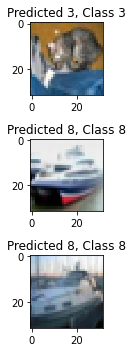

In [ ]:
plt.figure()
for i, correct in enumerate(correct_indices[:3]):
    plt.subplot(3,1,i+1)
    plt.imshow(X_val_original[correct], interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_val[correct][0]))
    
plt.tight_layout()

... and a few where the network is wrong!

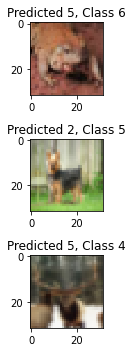

In [ ]:
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:3]):
    plt.subplot(3,1,i+1)
    plt.imshow(X_val_original[incorrect], interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_val[incorrect][0]))
    
plt.tight_layout()

## V- Network performances

Below the learning curves are displayed : 

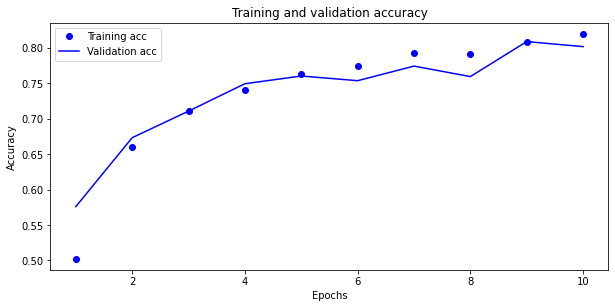

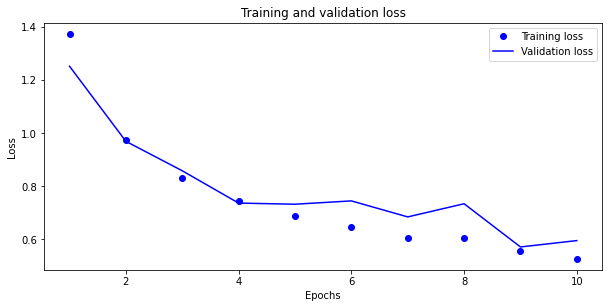

In [ ]:
history_dict = history.history
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger

# Plot the evolution of the accuracy during the training
# ------------------------------------------------------

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

n = len(acc_values)
epochs = range(1, n+1)

plt.subplot(2,1,1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the evolution of the loss during the training
# ------------------------------------------------------

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.subplot(2,1,2)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Since we are working with 10 different categories, it is often useful to look at the performances of the network for each category. Below, two different tools are used to display the results :
- **classification report** is creating a small summary of the network performances for each category, using different metrics
- **confusion matrix** is returning a matrix indicating for each classes the propotion of true positive detections as well as the proportions of false negative and to which classes they are assigned. 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['aiplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('Classification report :')
print('')
print(classification_report(np.argmax(Y_val, axis=1), predicted_classes, target_names=target_names))

print('')
print('Confusion matrix :')
print('')
print(np.around(confusion_matrix(np.argmax(Y_val, axis=1), predicted_classes)/1000,1))


Classification report :

              precision    recall  f1-score   support

     aiplane       0.84      0.85      0.85      1000
         car       0.92      0.89      0.90      1000
        bird       0.77      0.72      0.75      1000
         cat       0.73      0.54      0.62      1000
        deer       0.74      0.84      0.79      1000
         dog       0.65      0.83      0.73      1000
        frog       0.91      0.78      0.84      1000
       horse       0.78      0.91      0.84      1000
        ship       0.88      0.90      0.89      1000
       truck       0.92      0.85      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000


Confusion matrix :

[[0.9 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.9 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.7 0.  0.1 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.1 0.2 0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.8 0